In [1]:
from __future__ import annotations

from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree


class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr="add")  # "Add" aggregation (Step 5).
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        x = self.lin(x)

        # Step 3: Compute normalization.
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float("inf")] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        return self.propagate(edge_index, x=x, norm=norm)

    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]

        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_j

In [2]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root="data/Planetoid", name="Cora", transform=NormalizeFeatures())

print()
print(f"Dataset: {dataset}:")
print("======================")
print(f"Number of graphs: {len(dataset)}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes}")

data = dataset[0]

print(
    "==========================================================================================================="
)
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Average node degree: {data.num_edges / data.num_nodes:.2f}")
print(f"Number of training nodes: {data.train_mask.sum()}")
print(f"Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}")
print(f"Has isolated nodes: {data.has_isolated_nodes()}")
print(f"Has self-loops: {data.has_self_loops()}")
print(f"Is undirected: {data.is_undirected()}")


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


# Finding cliques

1. Load the data in our own representation and get all 3-cliques from the graph

In [3]:
"""Another class for dataset representation"""

from typing import Dict, List, Set, Optional

import torch
from torch import Tensor, LongTensor, BoolTensor
from torch_geometric.data import Data


class Node:
    """Representation of a node from dataset"""

    name: int
    features: Tensor
    label: int
    in_train_mask: bool
    in_test_mask: bool
    in_val_mask: bool

    def __init__(self, name: int, features: Tensor):
        """Create a new node by label and it's feature vector

        Args:
            name (int): Node's label (and index)
            features (Tensor): 1xF feature vector
        """
        self.name = name
        self.features = features

    def __lt__(self, other):
        return self.name < other.name

    def __str__(self):
        return f"Node(name={self.name})"

    def __repr__(self):
        return str(self)


class Graph:
    """Representation of dataset"""

    nodes: List[Node]
    adjacency_list: Dict[Node, Set[Node]]

    def __init__(self, data: Data):
        """Creates a graph from a piece of dataset

        Args:
            data (Data): Dataset
        """
        self.nodes = []
        self.adjacency_list = {}

        nodes_num = len(data.edge_index[0])

        for i in range(nodes_num):
            # find nodes associated with numbers
            source = self.__find_node_or_create(int(data.edge_index[0][i]), data.x)
            source.in_val_mask = data.val_mask[source.name]
            destination = self.__find_node_or_create(int(data.edge_index[1][i]), data.x)
            destination.in_val_mask = data.val_mask[destination.name]

            # add edges to `adjacency_list`
            self.__add_edge(source, destination)
            self.__add_edge(source=destination, destination=source)

    def __add_edge(self, source: Node, destination: Node):
        """Adds an edge (source, destination) to adjacency list"""
        # if key doesnt exist, create one with default value
        if self.adjacency_list.get(source, None) is None:
            self.adjacency_list[source] = set()

        self.adjacency_list[source].add(destination)

    def __find_node_or_create(self, name: int, feature_matrix: Tensor) -> Node:
        """Returns an existing node by name or creates one"""
        node = self.__find_node_by_name(name)
        if not node:
            node = Node(name, feature_matrix[name])
            self.nodes.append(node)
            self.adjacency_list[node] = set()
        return node

    def __find_node_by_name(self, name: int) -> Optional[Node]:
        """Finds a node by name. Returns `None` if node is not found"""
        for node in self.nodes:
            if node.name == name:
                return node
        return None

    def edge_exists(self, source: Node, destination: Node) -> bool:
        """Returns `True` if edge between source and destination exists

        Args:
            source (Node): Source node
            destination (Node): Target node

        Returns:
            bool: True if edge (source, destination) exists
        """
        return destination in self.adjacency_list[source]

    def nodes_form_3clique(self, a: Node, b: Node, c: Node) -> bool:
        """Returns True if 3 given nodes form a triangle (3-clique)

        Args:
            a (Node): Some node
            b (Node): Some node
            c (Node): Some node

        Returns:
            bool: True if any pair of given nodes has an edge between them
        """
        a_b = self.edge_exists(a, b)
        a_c = self.edge_exists(a, c)
        b_c = self.edge_exists(b, c)
        return a_b and a_c and b_c

    def get_all_3cliques(self) -> List[Tuple[Node, Node, Node]]:
        """Returns a list of 3-cliques.
        One node might belong to multiple 3-cliques.

        Returns:
            List[Tuple[Node, Node, Node]]: List of (Node, Node, Node)
        """
        result = set()

        for a in self.nodes:
            for b in self.adjacency_list[a]:
                common_neighbors = self.adjacency_list[a] & self.adjacency_list[b]

                for c in common_neighbors:
                    # Sort in order to remove duplicate cliques (a, b, c) is same as (c, a, b) and etc
                    clique = [a, b, c]
                    clique.sort()
                    result.add(tuple(clique))

        return list(result)

    def replace_3clique_with_node(self, clique: Tuple[Node, Node, Node]):
        """Merges nodes from a 3-clique into one node sharing their features

        Args:
            clique (Tuple[Node, Node, Node]): 3 Nodes forming a trianble
        """
        a, b, c = clique
        neighbors = (
                self.adjacency_list[a] | self.adjacency_list[b] | self.adjacency_list[c]
        )
        neighbors.remove(a)
        neighbors.remove(b)
        neighbors.remove(c)

        # remove all edges coming to these nodes
        for source in clique:
            for destination in self.adjacency_list[source]:
                self.adjacency_list[destination].remove(source)
            self.adjacency_list.pop(source)
            self.nodes.remove(source)

        # crate a "general" node
        common_features: Tensor = (a.features + b.features + c.features) / 3
        new_node_name = a.name
        common_node = Node(new_node_name, common_features)

        self.nodes.append(common_node)
        for neighbor in neighbors:
            self.__add_edge(common_node, neighbor)
            self.__add_edge(neighbor, common_node)

    def __rename_nodes(self, old_data: Data):
        """Generates new names for all the nodes

        Args:
            old_data (Data): _description_
        """
        # Dict [old_name, new_name]
        names = {}

        for ind, node in enumerate(self.nodes):
            node.label = int(old_data.y[node.name])
            node.in_test_mask = bool(old_data.test_mask[node.name])
            node.in_train_mask = bool(old_data.train_mask[node.name])
            node.in_val_mask = bool(old_data.val_mask[node.name])
            names[node.name] = ind
            node.name = ind

        # Rebuild adjacency list
        self.adjacency_list = {}

        for nd, nbr in zip(*old_data.edge_index):
            # fr, to = None, None
            try:
                fr = self.__find_node_by_name(names[int(nd)])
                to = self.__find_node_by_name(names[int(nbr)])
            except KeyError:
                continue
            if fr not in self.adjacency_list.keys():
                self.adjacency_list[fr] = set()

            self.adjacency_list[fr].add(to)

    def __generate_feature_tensor(self) -> Tensor:
        """Generates a tensor of features (known as `x`) from nodes"""
        matrix = []
        for node in self.nodes:
            matrix.append(list(node.features))

        return Tensor(matrix)

    def __get_number_of_edges(self) -> int:
        ans = 0
        for neighbors in self.adjacency_list.values():
            ans += len(neighbors)
        return ans

    def __generate_edge_index(self) -> Tensor:
        """Generates a 2xE tensor where all edges are stored"""
        # matrix: Tuple[List[int], List[int]] = ([], [])

        matrix = LongTensor(2, self.__get_number_of_edges())
        current_col = 0

        for node, neighbors in self.adjacency_list.items():
            for neighbor in neighbors:
                matrix[0][current_col] = int(node.name)
                matrix[1][current_col] = int(neighbor.name)
                current_col += 1

        return matrix

    def __get_node_fields(self, func_to_apply) -> Tensor:
        """
        Returns a tensor of node fields.
        Example:
        `__get_node_fields(lambda node: node.label` will return a tensor of all labels
        """
        return Tensor([func_to_apply(node) for node in self.nodes])

    # FIXME
    def __get_train_mask(self):
        res = torch.zeros((1, len(self.nodes)))

        for i, node in enumerate(self.nodes):
            res[i] = bool(node.in_train_mask)
        return res

    def get_graph_data(self, old_data: Data) -> Data:
        """Returns the `Data` (x, y, and all the boolean masks)
        created after performing manipulations on nodes

        Args:
            old_data (Data): the data of nodes before the transformation

        Returns:
            Data: new feature vector, answer vector and boolean masks
        """
        self.__rename_nodes(old_data)
        features = self.__generate_feature_tensor()  # [ [float] ]      (NxF matrix)
        edge_index = self.__generate_edge_index()  # [ [int], [int] ] (2xN matrix)
        labels = LongTensor(
            [int(node.label) for node in self.nodes]
        )  # [int]            (N vector)
        train_mask = BoolTensor(
            [bool(node.in_train_mask) for node in self.nodes]
        )  # [bool]           (N vector)
        test_mask = BoolTensor(
            [bool(node.in_test_mask) for node in self.nodes]
        )  # [bool]           (N vector)
        val_mask = BoolTensor(
            [bool(node.in_val_mask) for node in self.nodes]
        )  # [bool]           (N vector)
        return Data(
            x=features,
            edge_index=edge_index,
            y=labels,
            train_mask=train_mask,
            val_mask=val_mask,
            test_mask=test_mask,
        )

In [4]:
graph = Graph(data)

In [5]:
cliques = graph.get_all_3cliques()

2. Sort the cliques by given criteria. Currently it is sum of distances between all pairs of feature vectors: $\left| f_a - f_b \right| + \left| f_a - f_c \right| + \left| f_b - f_c \right|$ where $f_v$ is a feature vector of node $v$.

In [6]:
from numpy.linalg import norm
from typing import Tuple


def euclidean_distance(tup: Tuple[Node, Node, Node]) -> float:
    a, b, c = tup

    ab_len = norm(a.features - b.features)
    ac_len = norm(a.features - c.features)
    bc_len = norm(b.features - c.features)

    return ab_len + ac_len + bc_len


def manhattan_distance(tup: Tuple[Node, Node, Node]) -> float:
    def _manhattan(a_feat: Tensor, b_feat: Tensor) -> float:
        return sum(abs(a_feat - b_feat))

    a, b, c = tup

    ab_len = _manhattan(a.features, b.features)
    ac_len = _manhattan(a.features, c.features)
    bc_len = _manhattan(b.features, c.features)

    return ab_len + ac_len + bc_len


cliques.sort(key=euclidean_distance)

3. When the cliques are sorted, we want to do exactly one round of 3-clique-folding:
    - Take the clique with the smallest sum of distances
    - Take average ($\frac{1}{3} * \Sigma_{i = 0}^2\ f_i$) of their feature vectors, call it "common features"
    - Take all edges coming to all of the nodes from clique: $E\prime = \left\{ (v_k, v_j) | v_k \in (v_a, v_b, v_c),\ \neg j \in (a, b, c) \right\}$
    - Delete nodes $v_a$, $v_b$, $v_c$ and all of their edges from the graph
    - Create a new node with common features and all of the edges from $E\prime$

In [7]:
while len(cliques):
    top = cliques.pop(0)
    if not any([node.in_val_mask for node in top]):
        graph.replace_3clique_with_node(top)
        # delete all cliques containing any vertices from `top`
        cliques = list(
            filter(
                lambda cl: all([v not in cl for v in top]),
                cliques,
            )
        )

In [8]:
processed_data = graph.get_graph_data(data)

In [9]:
print("Default dataset:", data)
print("Processed dataset:", processed_data)
print()

nodes_removed_share = (data.num_nodes - processed_data.num_nodes) / data.num_nodes * 100
default_edges = len(data.edge_index[0])
processed_edges = len(processed_data.edge_index[0])
edges_removed_share = (default_edges - processed_edges) / default_edges * 100

print(f"Removed {round(nodes_removed_share, 2)}% of nodes")
print(f"Removed {round(edges_removed_share, 2)}% of edges")

Default dataset: Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Processed dataset: Data(x=[2326, 1433], edge_index=[2, 6200], y=[2326], train_mask=[2326], val_mask=[2326], test_mask=[2326])

Removed 14.11% of nodes
Removed 41.27% of edges


Now let us create 2 models: first one with default dataset, and the second one with preprocessed data where 3-cliques were merged in one node

In [10]:
default = GCNConv(in_channels=1433, out_channels=7)
cliques_merged = GCNConv(in_channels=1433, out_channels=7)

In [11]:
from time import time as current_time
import numpy as np


def tf_to_numpy(tf_list: list) -> np.array:
    return np.array([el.detach().numpy() for el in tf_list])


def train_and_test(model: GCNConv, data: Data, epochs_num: int, print_every: int):
    start_time = current_time()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()

    def train():
        model.train()
        optimizer.zero_grad()  # Clear gradients.
        out = model(data.x, data.edge_index)  # Perform a single forward pass.
        loss = criterion(
            out[data.train_mask], data.y[data.train_mask]
        )  # Compute the loss solely based on the training nodes.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        return loss

    def test():
        model.eval()
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        test_correct = (
                pred[data.test_mask] == data.y[data.test_mask]
        )  # Check against ground-truth labels.
        test_acc = int(test_correct.sum()) / int(
            data.test_mask.sum()
        )  # Derive ratio of correct predictions.
        print(f"Model accuracy: {test_acc}")
        return test_acc

    losses = []
    for epoch in range(1, epochs_num + 1):
        loss = train()
        losses.append(loss)
        if print_every > 1 and epoch % print_every == 0:
            print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}")
    end_time = current_time()
    print(f"Learning took {round(end_time - start_time, 2)} seconds")
    accuracy = test()
    return tf_to_numpy(losses), accuracy

In [12]:
default_losses, default_acc = train_and_test(default, data, epochs_num=300, print_every=30)

Epoch: 030, Loss: 1.7665
Epoch: 060, Loss: 1.6788
Epoch: 090, Loss: 1.6272
Epoch: 120, Loss: 1.5919
Epoch: 150, Loss: 1.5664
Epoch: 180, Loss: 1.5470
Epoch: 210, Loss: 1.5318
Epoch: 240, Loss: 1.5194
Epoch: 270, Loss: 1.5092
Epoch: 300, Loss: 1.5006
Learning took 2.37 seconds
Model accuracy: 0.726


In [13]:
cliques_merged_losses, merged_acc = train_and_test(cliques_merged, processed_data, epochs_num=300, print_every=30)

Epoch: 030, Loss: 1.7569
Epoch: 060, Loss: 1.6626
Epoch: 090, Loss: 1.6074
Epoch: 120, Loss: 1.5698
Epoch: 150, Loss: 1.5426
Epoch: 180, Loss: 1.5221
Epoch: 210, Loss: 1.5061
Epoch: 240, Loss: 1.4932
Epoch: 270, Loss: 1.4826
Epoch: 300, Loss: 1.4737
Learning took 2.02 seconds
Model accuracy: 0.6930051813471503


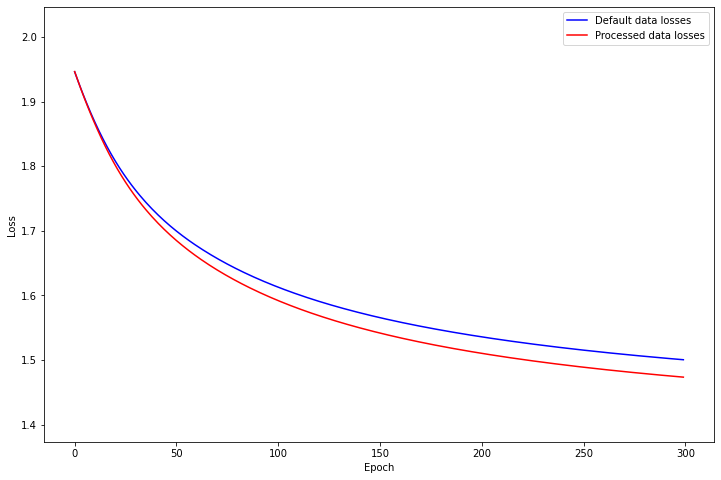

In [14]:
import matplotlib.pyplot as plt

assert len(default_losses) == len(cliques_merged_losses), "Loss vectors lengths differ!"

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(default_losses, color="blue", label="Default data losses")
ax.plot(cliques_merged_losses, color="red", label="Processed data losses")

plt.xlabel("Epoch")
plt.ylabel("Loss")

least_y = min(min(default_losses), min(cliques_merged_losses))
greatest_y = max(max(default_losses), max(cliques_merged_losses))

plt.ylim(
    (least_y - 0.1, greatest_y + 0.1)
)  # we add/subtract 0.1 in order to make the plot look nicer
plt.legend()
plt.show()

## Benchmark

Now, in order to calculate average accuracy, we ought to run $N$ iterations of `train_and_test` with $M$ epochs

In [15]:
N = 100
M = 300

In [16]:
default_accuracies = []
merged_accuracies = []

default_avg_losses = None
merged_avg_losses = None

In [17]:
from tqdm.notebook import tqdm

for _ in tqdm(range(N)):
    default = GCNConv(in_channels=1433, out_channels=7)
    cliques_merged = GCNConv(in_channels=1433, out_channels=7)

    default_losses, default_acc = train_and_test(default, data, epochs_num=M, print_every=0)
    merged_losses, merged_acc = train_and_test(cliques_merged, processed_data, epochs_num=M, print_every=0)

    default_accuracies.append(default_acc)
    merged_accuracies.append(merged_acc)

    if default_avg_losses is not None:
        default_avg_losses += default_losses
    else:
        default_avg_losses = default_losses

    if merged_avg_losses is not None:
        merged_avg_losses += merged_losses
    else:
        merged_avg_losses = merged_losses

  0%|          | 0/100 [00:00<?, ?it/s]

Learning took 2.23 seconds
Model accuracy: 0.725
Learning took 1.5 seconds
Model accuracy: 0.694300518134715
Learning took 1.75 seconds
Model accuracy: 0.725
Learning took 1.41 seconds
Model accuracy: 0.694300518134715
Learning took 1.63 seconds
Model accuracy: 0.725
Learning took 1.48 seconds
Model accuracy: 0.6968911917098446
Learning took 1.77 seconds
Model accuracy: 0.725
Learning took 1.64 seconds
Model accuracy: 0.6968911917098446
Learning took 1.97 seconds
Model accuracy: 0.725
Learning took 1.68 seconds
Model accuracy: 0.694300518134715
Learning took 1.62 seconds
Model accuracy: 0.725
Learning took 1.36 seconds
Model accuracy: 0.694300518134715
Learning took 1.69 seconds
Model accuracy: 0.725
Learning took 1.58 seconds
Model accuracy: 0.6955958549222798
Learning took 1.68 seconds
Model accuracy: 0.726
Learning took 1.36 seconds
Model accuracy: 0.694300518134715
Learning took 1.7 seconds
Model accuracy: 0.726
Learning took 1.44 seconds
Model accuracy: 0.6968911917098446
Learning

In [18]:
default_avg_losses /= N
merged_avg_losses /= N

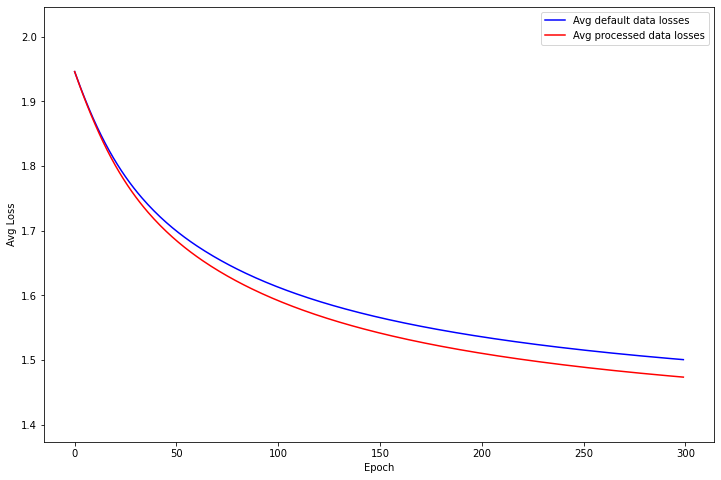

In [19]:
import matplotlib.pyplot as plt

assert len(default_avg_losses) == len(merged_avg_losses), "Loss vectors lengths differ!"

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(default_avg_losses, color="blue", label="Avg default data losses")
ax.plot(merged_avg_losses, color="red", label="Avg processed data losses")

plt.xlabel("Epoch")
plt.ylabel("Avg Loss")

least_y = min(min(default_avg_losses), min(merged_avg_losses))
greatest_y = max(max(default_avg_losses), max(merged_avg_losses))

plt.ylim(
    (least_y - 0.1, greatest_y + 0.1)
)  # we add/subtract 0.1 in order to make the plot look nicer
plt.legend()
plt.show()

This graph clearly shows us that preprocessing allows us to reduce loss, and, therefore, acheive same results faster. But what about accuracy?

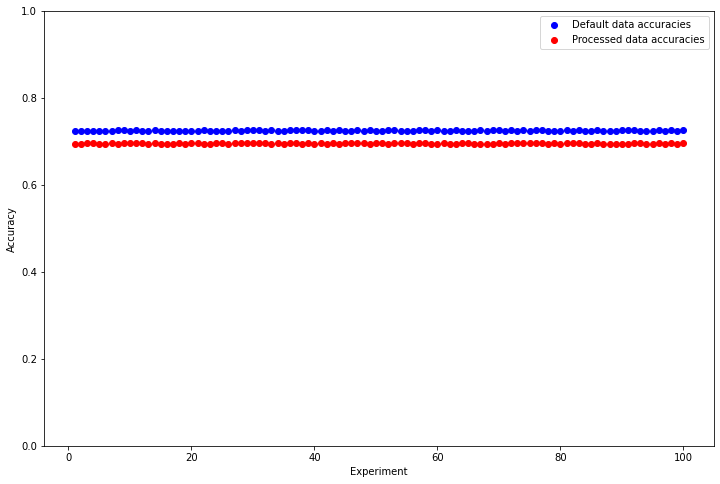

In [20]:
fig, ax = plt.subplots(figsize=(12, 8))

x = np.arange(1, 1 + N)

ax.scatter(x=x, y=default_accuracies, color="blue", label="Default data accuracies")
ax.scatter(x=x, y=merged_accuracies, color="red", label="Processed data accuracies")

plt.xlabel("Experiment")
plt.ylabel("Accuracy")

plt.ylim((0, 1))

plt.legend()
plt.show()

In [21]:
default_avg_acc = sum(default_accuracies) / N
merged_avg_acc = sum(merged_accuracies) / N

default_avg_acc - merged_avg_acc

0.03025341968911832

We can see that the accuracy has dropped approximately by 3%